In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from snorkel.labeling import LabelModel, MajorityLabelVoter, RandomVoter
from functools import partial
from modAL.batch import uncertainty_batch_sampling
from modAL.models import ActiveLearner
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder

# Set our RNG for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

In [2]:
def delete_rows_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    indices = list(indices)
    mask = np.ones(mat.shape[0], dtype=bool)
    mask[indices] = False
    return mat[mask]

In [3]:
# df = pd.read_csv("../../data/interim/address_train_data.csv", index_col='id')
df = pd.read_csv("../../data/interim/address_without_country_info.csv", index_col='id')

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

## Remove numbers from text

In [4]:
df['clean_address'] = df['address'].replace('\d+', '', regex=True)

## Balance dataset by force

In [5]:
t = df[df.label == True]
f = df[df.label == False]
small_f = f.iloc[np.random.randint(0, len(f), len(t)+1000)]
df_balanced = pd.concat([small_f, t])
df_balanced['label'].value_counts()

0    3000
1    2000
Name: label, dtype: int64

In [6]:
tfv = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,3), use_idf=False)

In [7]:
X_raw = tfv.fit_transform(df_balanced['clean_address']).toarray()
y_raw = df_balanced['label'].values
# X_raw.shape

In [8]:
# Isolate our examples for our labeled dataset.
BATCH_SIZE = 10
INITIAL_BATCH_SIZE = 40

n_labeled_examples = X_raw.shape[0]
training_indices = np.random.choice(n_labeled_examples, size=INITIAL_BATCH_SIZE, replace=False)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
# X_pool = delete_rows_csr(X_raw, training_indices)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [9]:
def random_sampling(classifier, X_pool, n_instances):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples), n_instances)
    return query_idx, X_pool[query_idx]

In [21]:
# Specify our active learning model.
rnd_learner = ActiveLearner(
  estimator=SGDClassifier(loss='log', random_state=1),

  X_training=X_train.copy(),
  y_training=y_train.copy(),

  query_strategy=partial(random_sampling, n_instances=BATCH_SIZE)
)

# Specify our active learning model.
al_learner = ActiveLearner(
  estimator=SGDClassifier(loss='log', random_state=1),

  X_training=X_train.copy(),
  y_training=y_train.copy(),

  query_strategy=partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)
)

In [11]:
def random_labels(y, fraction_of_random_labels=0.10, cardinality=3):
    mask = np.random.rand(*y.shape) < fraction_of_random_labels
    r = np.random.randint(0, cardinality, size = y.shape)
    y[mask] = r[mask]   
    return y

def fake_multi_user_labeling(y, n_labelers, only_zeroes_idx, fraction_of_random_labels=0.10, cardinality=None):
    y = np.tile(y, (n_labelers, 1)).transpose()
    y = random_labels(y, fraction_of_random_labels, cardinality)
    if only_zeroes_idx is not None:
        y[:,only_zeroes_idx] = 0
    return(y)

In [12]:
majority_voter = MajorityLabelVoter(cardinality=2)

In [15]:
def run_labeler(learner, X_pool, y_pool, n_queries=10, use_snorkel=False):
    
    if use_snorkel:
        label_model = LabelModel(cardinality=3, verbose=True)
    
    performance_history = [learner.score(X_raw, y_raw)]
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=0, acc=performance_history[0]))
    
    for index in range(n_queries):
        query_index, query_instance = learner.query(X_pool)

        # Teach our ActiveLearner model the record it has requested.
        X, y = X_pool[query_index], y_pool[query_index]
        y = fake_multi_user_labeling(y, n_labelers = 3, only_zeroes_idx = 0, cardinality=2)

        label_model.fit(L_train=y, n_epochs=1000, lr=0.001, log_freq=100, seed=123)
        
        preds_queried = label_model.predict(L=y)

        learner.teach(X=X, y=preds_queried) #, only_new=True)

        # Remove the queried instance from the unlabeled pool.
        X_pool = np.delete(X_pool, query_index, axis=0)
        y_pool = np.delete(y_pool, query_index)

        # Calculate and report our model's accuracy.
        model_accuracy = learner.score(X_pool, y_pool)
        print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

        # Save our model's performance for plotting.
        performance_history.append(model_accuracy)
    
    return performance_history

performance_hist = {
    'rnd': run_labeler(rnd_learner, X_pool, y_pool, use_snorkel=True),
    'al': run_labeler(al_learner, X_pool, y_pool, use_snorkel=True)
}

Accuracy after query 0: 0.8192
Accuracy after query 1: 0.8364
Accuracy after query 2: 0.8755
Accuracy after query 3: 0.8665
Accuracy after query 4: 0.8671
Accuracy after query 5: 0.9332
Accuracy after query 6: 0.9359
Accuracy after query 7: 0.9389
Accuracy after query 8: 0.9408
Accuracy after query 9: 0.9610
Accuracy after query 10: 0.9665
Accuracy after query 0: 0.8192
Accuracy after query 1: 0.9038
Accuracy after query 2: 0.9225
Accuracy after query 3: 0.9410
Accuracy after query 4: 0.9600
Accuracy after query 5: 0.9676
Accuracy after query 6: 0.9665
Accuracy after query 7: 0.9728
Accuracy after query 8: 0.9777
Accuracy after query 9: 0.9706
Accuracy after query 10: 0.9720


In [18]:
for perf in performance_hist["rnd"]:
    print(perf)

0.8192
0.8363636363636363
0.8755060728744939
0.8665314401622718
0.8670731707317073
0.9331975560081467
0.9359183673469388
0.9388548057259714
0.9407786885245901
0.9609856262833676
0.9664609053497942


In [19]:
for perf in performance_hist["al"]:
    print(perf)

0.8192
0.9038383838383839
0.9224696356275304
0.940973630831643
0.9599593495934959
0.9676171079429735
0.966530612244898
0.97280163599182
0.9776639344262295
0.9706365503080082
0.9720164609053498


In [22]:
def run_labeler(learner, X_pool, y_pool, n_queries=10, use_snorkel=False):
    
    if use_snorkel:
        label_model = LabelModel(cardinality=3, verbose=True)
    
    performance_history = [learner.score(X_raw, y_raw)]
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=0, acc=performance_history[0]))
    
    for index in range(n_queries):
        query_index, query_instance = learner.query(X_pool)

        # Teach our ActiveLearner model the record it has requested.
        X, y = X_pool[query_index], y_pool[query_index]
        y = fake_multi_user_labeling(y, n_labelers = 3, only_zeroes_idx = 0, cardinality=2)

        label_model.fit(L_train=y, n_epochs=1000, lr=0.001, log_freq=100, seed=123)
        
        preds_queried = label_model.predict(L=y)

        learner.teach(X=X, y=preds_queried) #, only_new=True)

        # Remove the queried instance from the unlabeled pool.
        X_pool = np.delete(X_pool, query_index, axis=0)
        y_pool = np.delete(y_pool, query_index)

        # Calculate and report our model's accuracy.
        model_accuracy = learner.score(X_pool, y_pool)
        print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

        # Save our model's performance for plotting.
        performance_history.append(model_accuracy)
    
    return performance_history

performance_hist = {
    'rnd': run_labeler(rnd_learner, X_pool, y_pool, use_snorkel=True),
    'al': run_labeler(al_learner, X_pool, y_pool, use_snorkel=True)
}

Accuracy after query 0: 0.8192
Accuracy after query 1: 0.8558
Accuracy after query 2: 0.8644
Accuracy after query 3: 0.8886
Accuracy after query 4: 0.8870
Accuracy after query 5: 0.9004
Accuracy after query 6: 0.9341
Accuracy after query 7: 0.9460
Accuracy after query 8: 0.9525
Accuracy after query 9: 0.9470
Accuracy after query 10: 0.9687
Accuracy after query 0: 0.8192
Accuracy after query 1: 0.9038
Accuracy after query 2: 0.9225
Accuracy after query 3: 0.9410
Accuracy after query 4: 0.9600
Accuracy after query 5: 0.9676
Accuracy after query 6: 0.9665
Accuracy after query 7: 0.9728
Accuracy after query 8: 0.9777
Accuracy after query 9: 0.9706
Accuracy after query 10: 0.9720


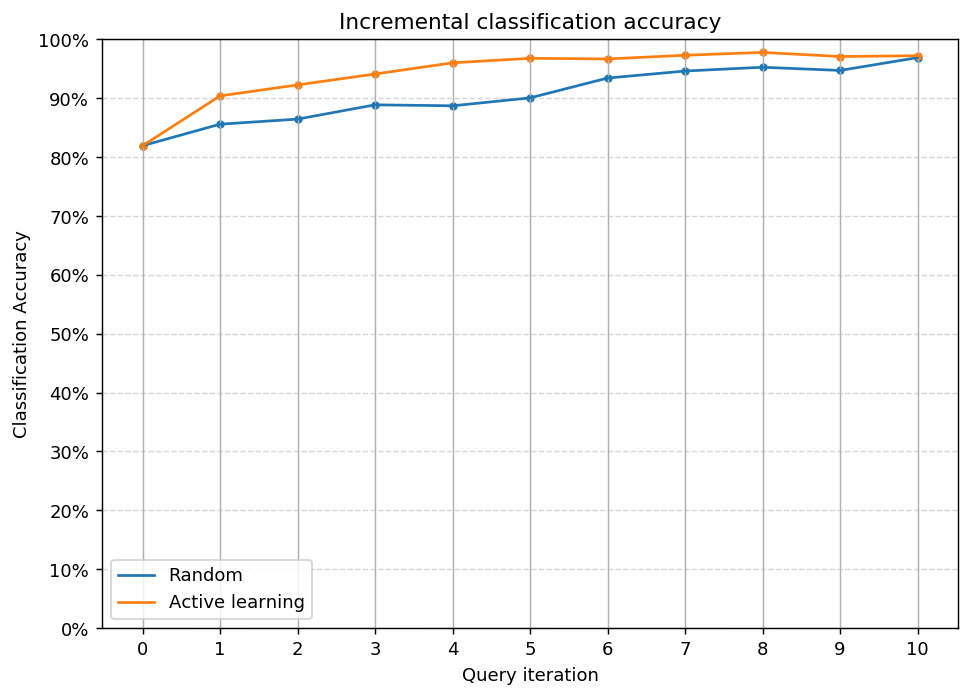

In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

N_QUERIES = 10

# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_hist['rnd'], label='Random')
ax.plot(performance_hist['al'], label='Active learning')

plt.legend(loc='lower left')

ax.scatter(range(len(performance_hist['rnd'])), performance_hist['rnd'], s=13)
ax.scatter(range(len(performance_hist['al'])), performance_hist['al'], s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=N_QUERIES + 3, integer=True))
ax.xaxis.grid(True)

ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0, top=1)
ax.yaxis.grid(True, linestyle='--', alpha=1/2)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

NameError: name 'performance_history' is not defined

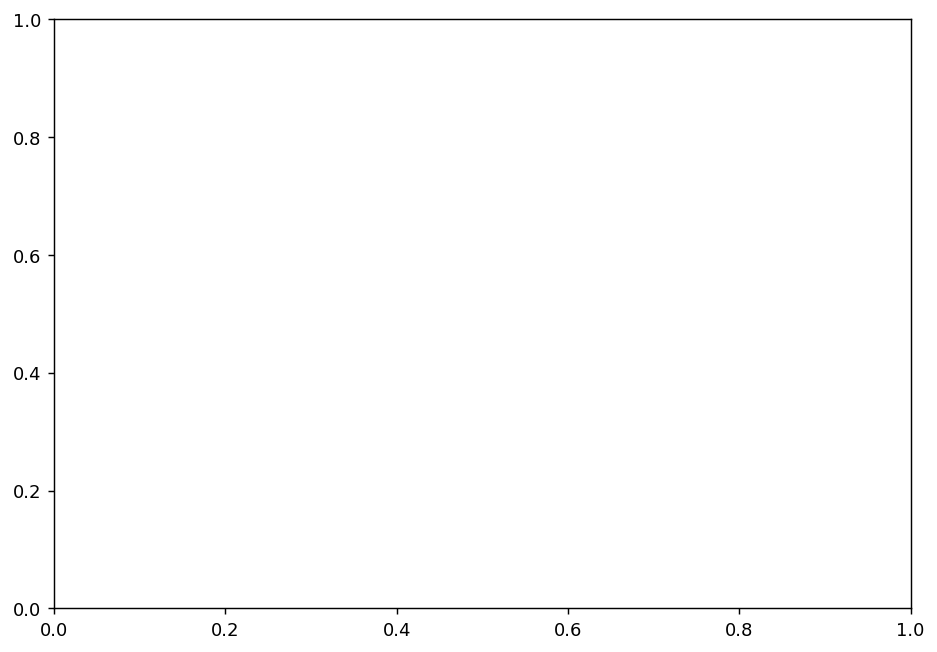

In [23]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=N_QUERIES + 3, integer=True))
ax.xaxis.grid(True)

ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0, top=1)
ax.yaxis.grid(True, linestyle='--', alpha=1/2)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()